# SPSS Modelerのデータ分割ノードをPythonで書き換える。ビン化、ランク付け処理


■利用データ<BR>
ID付POSデータを対象に行います。
誰（CUSTID）がいつ（SDATE）何（PRODUCTID、L_CLASS商品大分類、M_CLASS商品中分類）をいくら（SUBTOTAL）購入したかが記録されたID付POSデータを使います。<BR>
これを誰（CUSTID）が全部でいくら（SUBTOTAL_sum）購入したかというデータに集計してから使います。
    
![image.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/223763/5ec0d710-963b-a6ae-a88d-d94f1708f818.png)


In [1]:
!wget https://github.com/hkwd/200611Modeler2Python/raw/master/data/sampletranDEPT4en2019S.csv

In [2]:
#データの読み込み
import types
import pandas as pd

pd.options.display.max_rows = 10
#print(pd.options.display.max_rows)

import pandas as pd
df = pd.read_csv('sampletranDEPT4en2019S.csv')
print(df.dtypes)
df

CUSTID        int64
SDATE        object
PRODUCTID     int64
L_CLASS      object
M_CLASS      object
SUBTOTAL      int64
dtype: object


,CUSTID,SDATE,PRODUCTID,L_CLASS,M_CLASS,SUBTOTAL
0,100001,2019-07-02,9937845,BAG,BAG01,1740
1,100001,2019-07-09,9903878,BAG,BAG01,3108
2,100001,2019-08-08,9922209,COSMETICS,COSMETICS03,2888
3,100001,2019-08-18,9901187,SHOES,SHOES02,2700
4,100001,2019-08-26,9910507,COSMETICS,COSMETICS03,3385
...,...,...,...,...,...,...
28594,105978,2019-03-13,9913446,SHOES,SHOES02,3658
28595,105978,2019-05-10,9941252,SHOES,SHOES01,14478
28596,105978,2019-05-10,9905242,SHOES,SHOES02,1665
28597,105978,2019-09-04,9905242,SHOES,SHOES02,4050


In [3]:
df_cust_total=df[['CUSTID','SUBTOTAL']].groupby(['CUSTID']).sum()
df_cust_total

,SUBTOTAL
CUSTID,
100001,44386
100004,63615
100006,8200
100008,24951
100012,72866
...,...
105967,64780
105970,245616
105972,38744


# ① 分位数、デシル分析


In [4]:
#分位数
df_cust=df_cust_total.copy()
df_cust['DECIL'],decil_bins=pd.qcut(df_cust['SUBTOTAL'],10,labels=False,retbins=True)
df_cust['DECIL']=10-df_cust['DECIL']
print(df_cust)
print(decil_bins)

        SUBTOTAL  DECIL
CUSTID                 
100001     44386      4
100004     63615      3
100006      8200      9
100008     24951      6
100012     72866      2
...          ...    ...
105967     64780      3
105970    245616      1
105972     38744      4
105974    142537      1
105978     25447      6

[2744 rows x 2 columns]
[  1009.    4924.8   9175.   14156.1  19777.6  27265.   36808.4  49254.
  70421.6 112361.1 828844. ]


https://www.geeksforgeeks.org/quantile-and-decile-rank-of-a-column-in-pandas-python/

In [5]:
#デシルの構成比
df_decil=df_cust.groupby('DECIL').sum().sort_index()
df_decil['構成比']=df_decil['SUBTOTAL']/df_cust['SUBTOTAL'].sum()
df_decil['累積構成比']=df_decil['SUBTOTAL'].cumsum()/df_cust['SUBTOTAL'].sum()
df_decil

,SUBTOTAL,構成比,累積構成比
DECIL,,,
1,56247689,0.418456,0.418456
2,24514673,0.182377,0.600833
3,16091132,0.119710,0.720544
4,11770675,0.087568,0.808112
5,8735820,0.064990,0.873102
6,6402860,0.047634,0.920736
7,4660015,0.034668,0.955405
8,3204628,0.023841,0.979245
9,1957709,0.014564,0.993810


# ②固定幅：ビン数指定　


In [6]:
df_cust_total['SUBTOTAL'].min()

1009

In [7]:
#固定幅：ビン数指定
df_cust2=df_cust_total.copy()
df_cust2['BIN'],fixed_bins=pd.cut(df_cust2['SUBTOTAL'],10,labels=False,retbins=True)
print(df_cust2)
import numpy as np
np.set_printoptions(suppress=True)
print(fixed_bins)

        SUBTOTAL  BIN
CUSTID               
100001     44386    0
100004     63615    0
100006      8200    0
100008     24951    0
100012     72866    0
...          ...  ...
105967     64780    0
105970    245616    2
105972     38744    0
105974    142537    1
105978     25447    0

[2744 rows x 2 columns]
[   181.165  83792.5   166576.    249359.5   332143.    414926.5
 497710.    580493.5   663277.    746060.5   828844.   ]


In [8]:
df_cust2_bin=df_cust2.groupby(['BIN']).count().rename(columns={'SUBTOTAL':'COUNT'})
df_cust2_bin['構成比']=df_cust2_bin['COUNT']/df_cust2_bin['COUNT'].sum()
df_cust2_bin


,COUNT,構成比
BIN,,
0,2300,0.838192
1,322,0.117347
2,65,0.023688
3,27,0.009840
4,12,0.004373
5,5,0.001822
6,7,0.002551
7,1,0.000364
8,3,0.001093


<AxesSubplot:xlabel='BIN'>

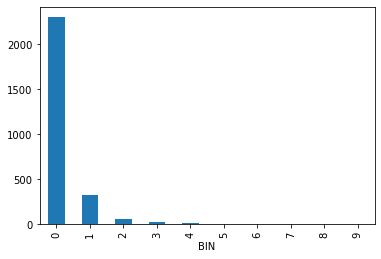

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
df_cust2_bin['COUNT'].plot.bar()


# ③ランク付け

In [10]:
#ランク
df_cust3=df_cust_total.copy()
df_cust3['rank']=df_cust3['SUBTOTAL'].rank(ascending=False)
df_cust3=df_cust3.sort_values(['rank'])
df_cust3['p_rank']=df_cust3['rank']/len(df_cust3)
df_cust3

,SUBTOTAL,rank,p_rank
CUSTID,,,
102045,828844,1.0,0.000364
102931,755873,2.0,0.000729
105667,725714,3.0,0.001093
105539,712566,4.0,0.001458
101628,677700,5.0,0.001822
...,...,...,...
104042,1050,2740.0,0.998542
100930,1048,2741.0,0.998907
100979,1034,2742.0,0.999271


In [11]:
import sys

print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [12]:
print(pd.__version__)

1.0.5
